In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [127]:
from astropy.cosmology import Planck18
import astropy.units as u
from gwpy.timeseries import TimeSeries
from gwpy.frequencyseries import FrequencySeries
import lal
import lalsimulation as lalsim
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig

In [183]:
fref = 5
fmin = fref
z0 = 2.0
srate = 4096.0
hp, hc = lalsim.SimInspiralChooseTDWaveform(1.4*lal.MSUN_SI*(1+z0), 1.4*lal.MSUN_SI*(1+z0), 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, Planck18.luminosity_distance(z0).to(u.Gpc).value*1e9*lal.PC_SI, 
                                            0.0, 0.0, 0.0, 0.0, 0.0, 1.0/srate, fmin, fref, None, lalsim.TaylorT4)

In [184]:
z1 = 1.0
hp1, hc1 = lalsim.SimInspiralChooseTDWaveform(1.4*lal.MSUN_SI*(1+z1), 1.4*lal.MSUN_SI*(1+z1), 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, Planck18.luminosity_distance(z1).to(u.Gpc).value*1e9*lal.PC_SI, 
                                              0.0, 0.0, 0.0, 0.0, 0.0, 1.0/srate, fmin, fref, None, lalsim.TaylorT4)

Text(0, 0.5, 'Strain')

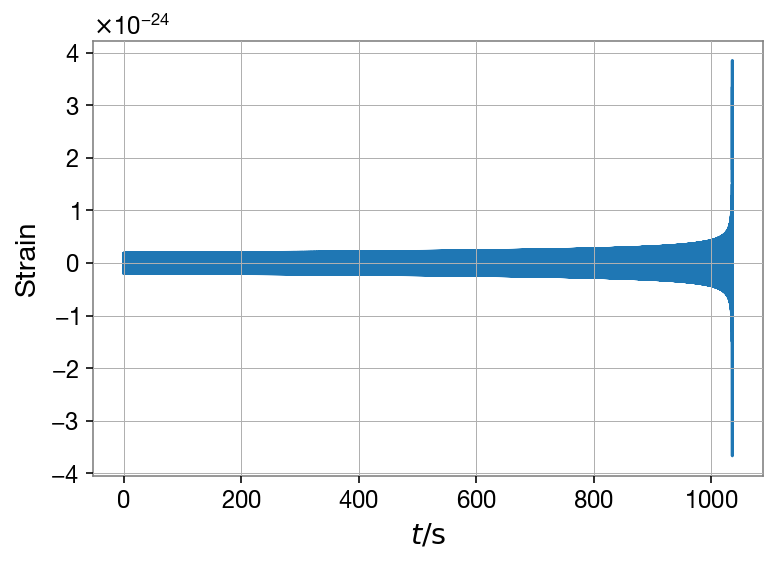

In [185]:
plt.plot(1/srate*np.arange(0, hp.data.data.shape[0]), hp.data.data)
plt.xlabel(r'$t / \mathrm{s}$')
plt.ylabel(r'Strain')

In [186]:
T = hp.data.data.shape[0]/srate
f0 = 5
df = 1/T
psd = lal.CreateREAL8FrequencySeries('psd', 0, f0, df, None, hp.data.data.shape[0]//2+1)
lalsim.SimNoisePSDCosmicExplorerP1600143(psd, 0)
psd.data.data[0] = psd.data.data[1]
psd.data.data[-1] = psd.data.data[-2]
psd_centered = 0.5*(psd.data.data[1:] + psd.data.data[:-1])

noise = lal.CreateREAL8TimeSeries('noise', 0, 0, 1.0/srate, lal.StrainUnit, hp.data.data.shape[0])
lalsim.SimNoise(noise, hp.data.data.shape[0], psd, lal.gsl_rng('default', np.random.randint(1<<31)))

0

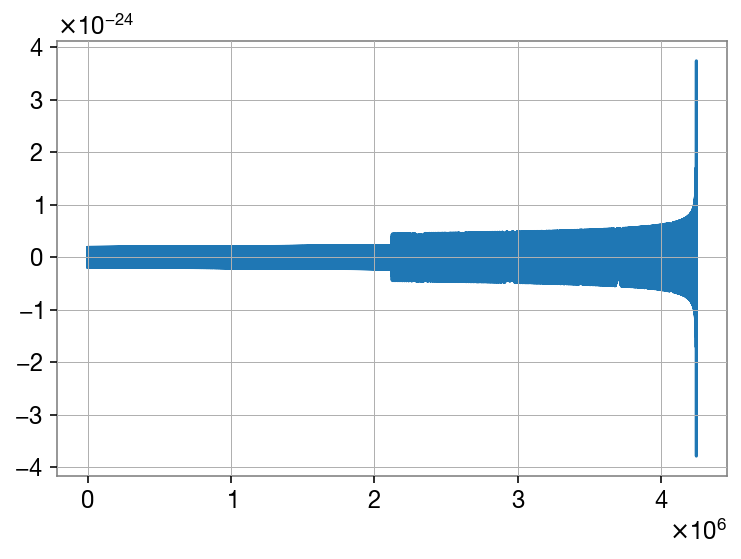

In [192]:
plt.plot(ts_data)

In [197]:
ts_data = hp.data.data + noise.data.data
N = ts_data.shape[0]
ts_data[:N//2] += hp1.data.data[-(N-N//2):]
h_timeseries = TimeSeries(ts_data, sample_rate=srate, epoch=0)
asd = FrequencySeries(np.sqrt(psd.data.data), f0=f0, df=df)
qs = h_timeseries.q_transform(frange=(4, 50), logf=True, whiten=True, qrange=(200, 200))

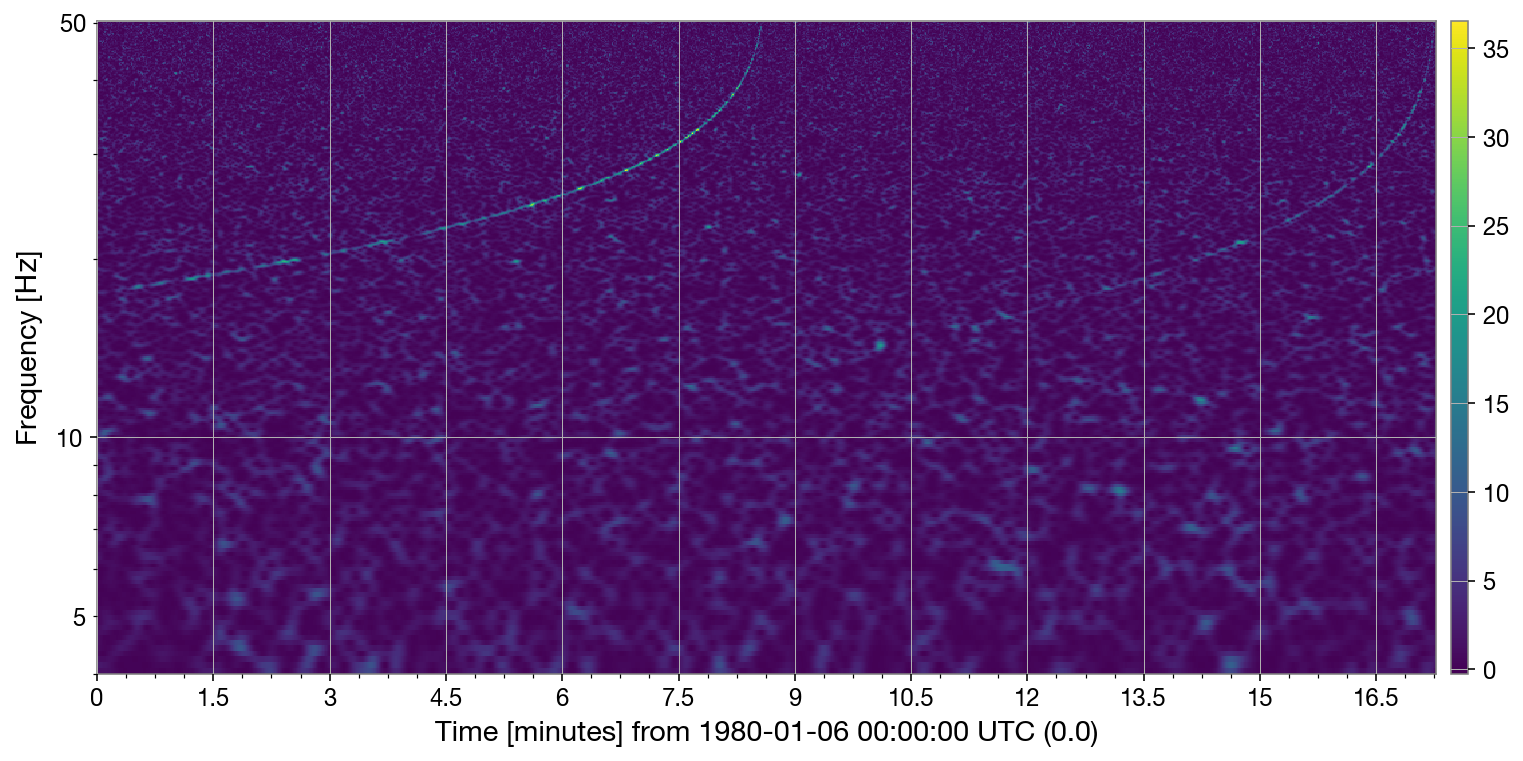

In [198]:
qs.plot(yscale='log')
ax = plt.gca()
ax.colorbar()